# 얼굴인식 final model

In [ ]:
pip install ultralytics

In [19]:
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import dlib, keras, sys, cv2, os, random
from keras.models import Model, load_model
from math import atan2, degrees

이미지 삽입을 위한 함수들 정의

In [20]:
# overlay function
def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    bg_img = background_img.copy()
    # 투명도가 없는 경우, 투명도 RGBA(4채널)로 색상변환
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)
    # 컬러채널별로 분리하기
    b, g, r, a = cv2.split(img_to_overlay_t)
    # 투명도 층 : 부드럽게 삽입되도록 blur처리
    mask = cv2.medianBlur(a, 5)
    mask = mask.astype(np.uint8)
    h, w, _ = img_to_overlay_t.shape
    # 배경 이미지에서 오버레이 될 영역 설정
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)
    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)
    # 다시 투명도 층 제거하고 3채널 층으로 변환
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)
    return bg_img

def angle_between(p1, p2):
    xDiff = p2[0] - p1[0]
    yDiff = p2[1] - p1[1]
    return degrees(atan2(yDiff, xDiff))

모델 로드  
bounding box detection : 데이터셋으로 학습한 YOLOv8n모델(best_1.pt)  
landmark detection : dlib 모듈(landmarkDetector.dat)

In [71]:
#모델 로드
BBS_MODEL_PATH = '/content/drive/MyDrive/Aiffel/DLthon/detectors/model/best_1.pt'
LMKS_MODEL_PATH = '/content/drive/MyDrive/Aiffel/DLthon/detectors/landmarkDetector.dat'

detector = YOLO(BBS_MODEL_PATH )
predictor = dlib.shape_predictor(LMKS_MODEL_PATH)

### 고양이


0: 608x480 1 cat, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 480)


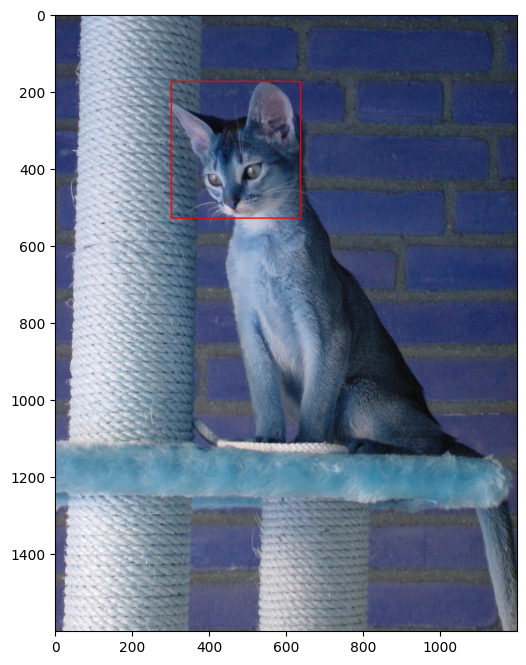

In [82]:
# 예측할 이미지 경로
image_path = '/content/drive/MyDrive/Aiffel/DLthon/dataset/cats/Abyssinian_29.jpg'

# 이미지 로드
image = cv2.imread(image_path)
original_image = image.copy()
bbox_image = image.copy()

# b-box예측
results = detector(image)

x1, y1, x2, y2 = results[0].boxes.xyxy[0].tolist()
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

# b-box 그리려면 활성화하기
cv2.rectangle(bbox_image, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
plt.figure(figsize=(8, 8))
plt.imshow(bbox_image)

face = dlib.rectangle(x1, y1, x2, y2)

shape = predictor(original_image, face)
shape = face_utils.shape_to_np(shape)

In [74]:
# 삽입할 이미지
glasses_path = '/content/drive/MyDrive/Aiffel/DLthon/insert_img/sunglass.png'
nose_path = '/content/drive/MyDrive/Aiffel/DLthon/insert_img/nose.png'
earring_path = '/content/drive/MyDrive/Aiffel/DLthon/insert_img/earring.png'
hat_path = '/content/drive/MyDrive/Aiffel/DLthon/insert_img/hat.png'

하단중에 넣고싶은거 고르기

선글삽입

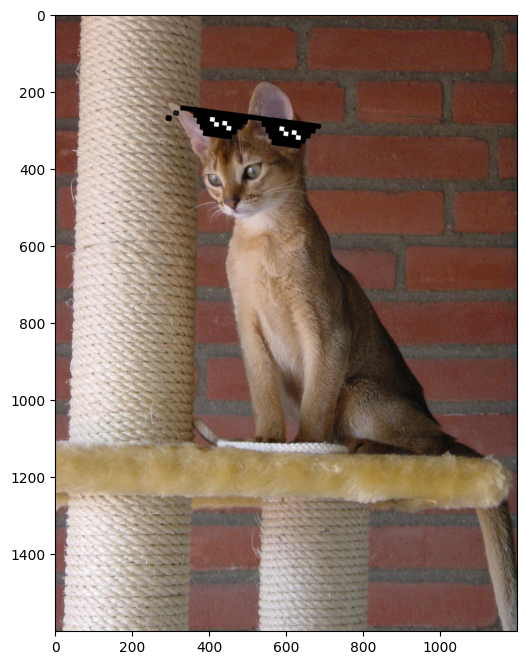

In [83]:
result_image = image.copy()

glasses_center = np.mean([shape[5], shape[2]], axis=0)
glasses_size = np.linalg.norm(shape[5]- shape[2]) * 4
angle = -angle_between(shape[5], shape[2])
glasses = cv2.imread(glasses_path, cv2.IMREAD_UNCHANGED)
M = cv2.getRotationMatrix2D((glasses.shape[1] / 2, glasses.shape[0] / 2), angle, 1)
rotated_glasses = cv2.warpAffine(glasses, M, (glasses.shape[1], glasses.shape[0]))
try:
    result_image = overlay_transparent(result_image, rotated_glasses, glasses_center[0], glasses_center[1], overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])))
except:
    glasses_size *= 0.5
    result_image = overlay_transparent(result_image, rotated_glasses, glasses_center[0], glasses_center[1], overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

코 삽입

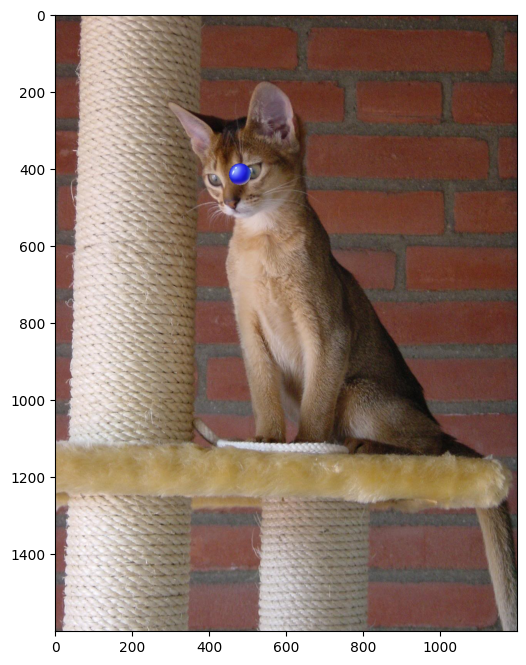

In [84]:
result_image = image.copy()

nose_center = shape[3]
nose = cv2.imread(nose_path, cv2.IMREAD_UNCHANGED)
nose_size = np.linalg.norm(shape[5]- shape[2]) * 0.5
nose = cv2.resize(nose, (int(nose_size), int(nose_size)))
result_image = overlay_transparent(result_image, nose, nose_center[0], nose_center[1], overlay_size=(nose.shape[1], nose.shape[0]))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

귀걸이 삽입

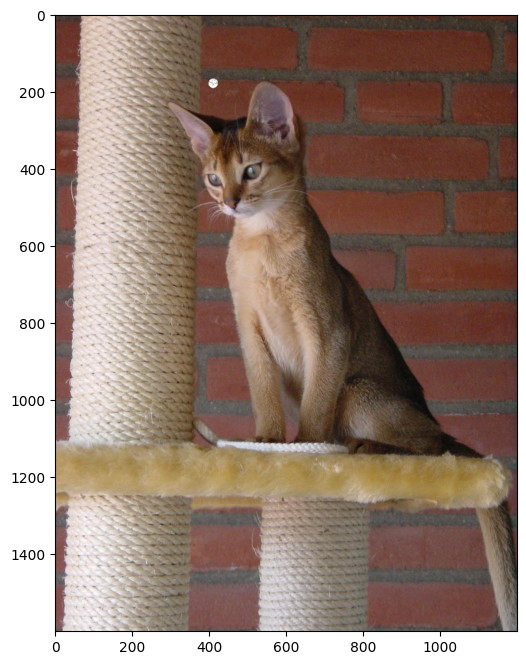

In [85]:
result_image = image.copy()

earring_center_left = shape[4]
earring = cv2.imread(earring_path, cv2.IMREAD_UNCHANGED)
earring_size = int(np.linalg.norm((shape[0]-shape[4])*0.8))
earring= cv2.resize(earring, (earring_size, earring_size))
result_image = overlay_transparent(result_image, earring, earring_center_left[0], earring_center_left[1], overlay_size=(earring.shape[1], earring.shape[0]))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

모자삽입

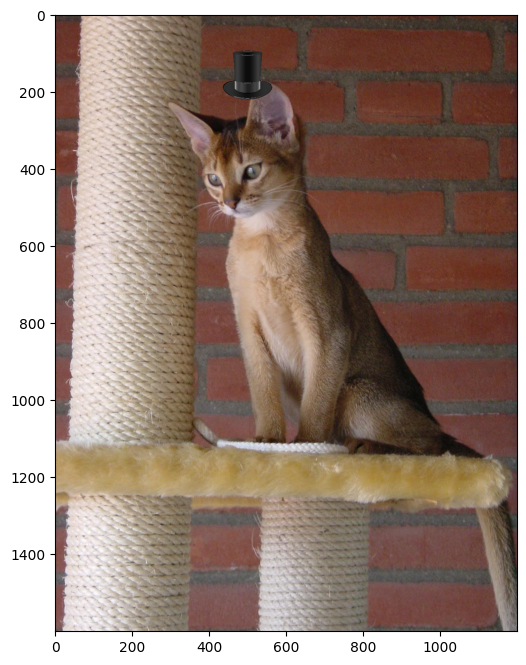

In [86]:
result_image = image.copy()

hat_center = [shape[0][0], shape[0][1]-7]    # shape[0]의 위치가 정수리보다 조금 위쪽인 경향이 있어 위치 조정
hat = cv2.imread(hat_path, cv2.IMREAD_UNCHANGED)
hat_size = np.linalg.norm(shape[0][1])*0.8
hat = cv2.resize(hat, (int(hat_size), int(hat_size)))
result_image = overlay_transparent(result_image, hat, hat_center[0], hat_center[1], overlay_size=(hat.shape[1], hat.shape[0]))


result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

### 강아지


0: 480x608 1 cat, 156.5ms
Speed: 2.8ms preprocess, 156.5ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 608)


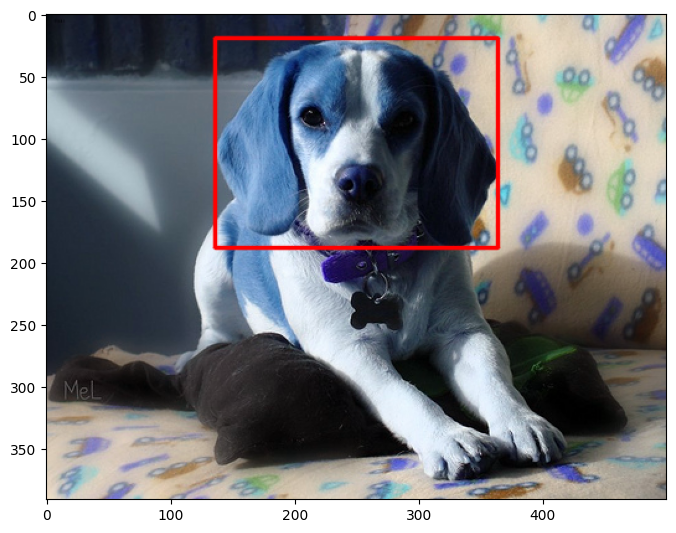

In [72]:
# 예측할 이미지 경로
image_path = '/content/drive/MyDrive/Aiffel/DLthon/dataset/dogs/beagle_20.jpg'

# 이미지 로드
image = cv2.imread(image_path)
original_image = image.copy()
bbox_image = image.copy()

# b-box예측
results = detector(image)

x1, y1, x2, y2 = results[0].boxes.xyxy[0].tolist()
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

# b-box 그리려면 활성화하기
cv2.rectangle(bbox_image, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
plt.figure(figsize=(8, 8))
plt.imshow(bbox_image)

face = dlib.rectangle(x1, y1, x2, y2)

shape = predictor(original_image, face)
shape = face_utils.shape_to_np(shape)

하단중에 넣고싶은거 고르기

선글삽입

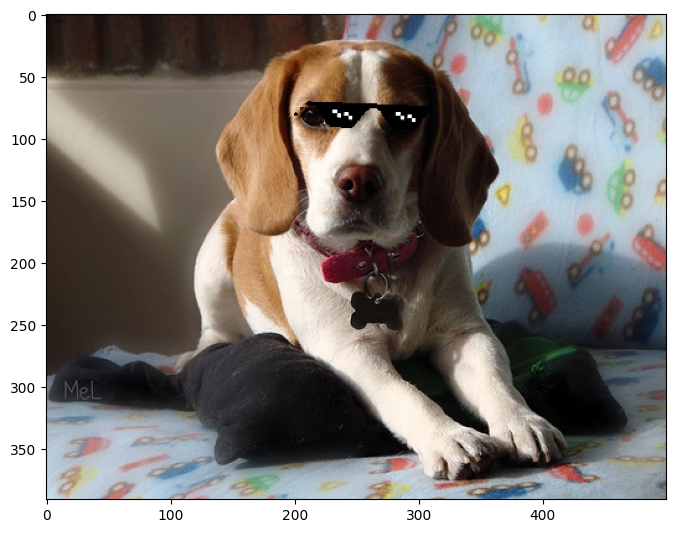

In [75]:
result_image = image.copy()

glasses_center = np.mean([shape[5], shape[2]], axis=0)
glasses_size = np.linalg.norm(shape[5]- shape[2]) * 4
angle = -angle_between(shape[5], shape[2])
glasses = cv2.imread(glasses_path, cv2.IMREAD_UNCHANGED)
M = cv2.getRotationMatrix2D((glasses.shape[1] / 2, glasses.shape[0] / 2), angle, 1)
rotated_glasses = cv2.warpAffine(glasses, M, (glasses.shape[1], glasses.shape[0]))
try:
    result_image = overlay_transparent(result_image, rotated_glasses, glasses_center[0], glasses_center[1], overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])))
except:
    glasses_size *= 0.5
    result_image = overlay_transparent(result_image, rotated_glasses, glasses_center[0], glasses_center[1], overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

코 삽입

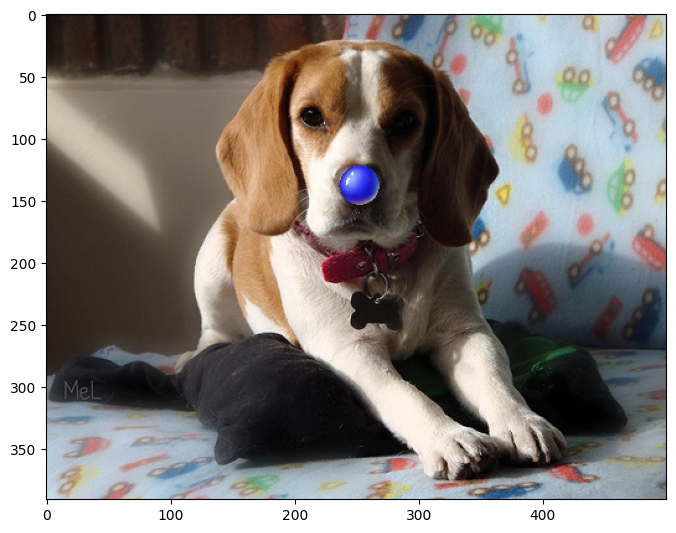

In [76]:
result_image = image.copy()

nose_center = shape[3]
nose = cv2.imread(nose_path, cv2.IMREAD_UNCHANGED)
nose_size = np.linalg.norm(shape[5]- shape[2]) * 0.5
nose = cv2.resize(nose, (int(nose_size), int(nose_size)))
result_image = overlay_transparent(result_image, nose, nose_center[0], nose_center[1], overlay_size=(nose.shape[1], nose.shape[0]))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

귀걸이 삽입

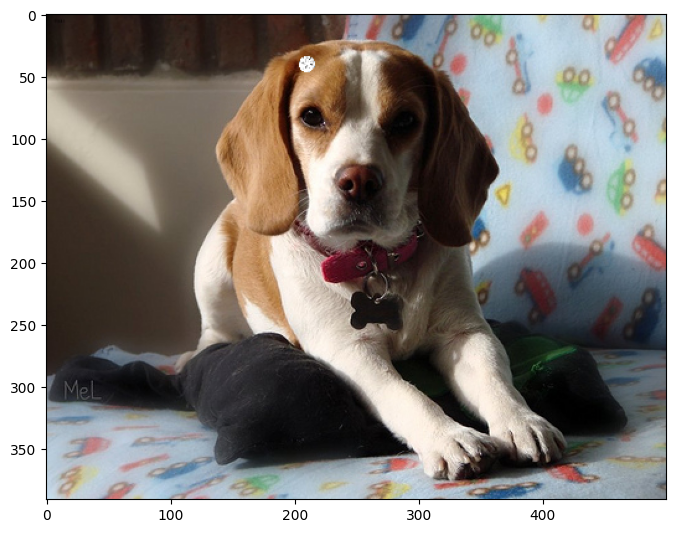

In [77]:
result_image = image.copy()

earring_center_left = shape[4]
earring = cv2.imread(earring_path, cv2.IMREAD_UNCHANGED)
earring_size = int(np.linalg.norm((shape[0]-shape[4])*0.8))
earring= cv2.resize(earring, (earring_size, earring_size))
result_image = overlay_transparent(result_image, earring, earring_center_left[0], earring_center_left[1], overlay_size=(earring.shape[1], earring.shape[0]))

result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)

모자삽입

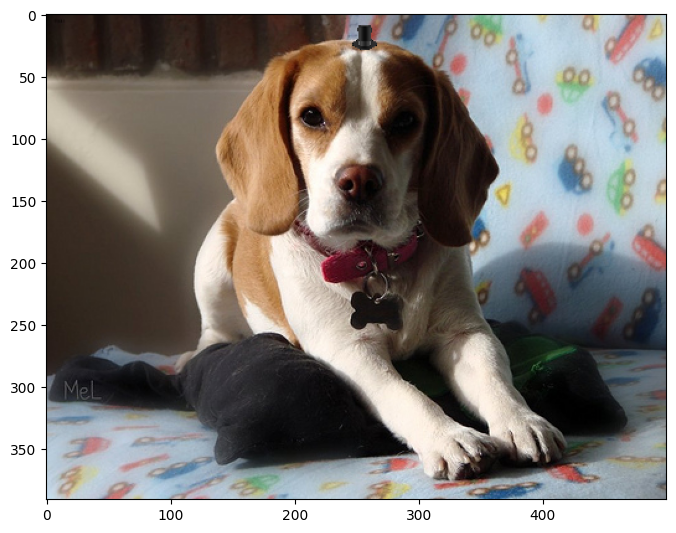

In [81]:
result_image = image.copy()

hat_center = [shape[0][0], shape[0][1]-7]
hat = cv2.imread(hat_path, cv2.IMREAD_UNCHANGED)
hat_size = np.linalg.norm(shape[0][1])*0.8  #머리 위 공간이 보다 hat size가 크면 삽입에러가남. 빈 공간의 0.8배 크기로 설정
hat = cv2.resize(hat, (int(hat_size), int(hat_size)))
result_image = overlay_transparent(result_image, hat, hat_center[0], hat_center[1], overlay_size=(hat.shape[1], hat.shape[0]))


result_image= cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)